In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import os, sys
if '..' not in sys.path:
    sys.path.append('..')
sys.path
os.chdir('c:\\Users\\Reuven\\PycharmProjects\\ProjectA')

In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import argparse
from typing import Iterable, List, Tuple, Any, Dict, Union
import mediapipe as mp


Point = Tuple[int, int]
Rect = Tuple[int, int, int, int]
Image = np.ndarray

from Project_A.utils.keyboard_segmentation import KeyboardSegmentation
from Project_A.utils.hand_segmentation import HandSegmentation
from Project_A.utils.mouse_segmentation import MouseSegmentation
from Project_A.utils.keyboard_layout import Key, Keyboard_Layout


In [65]:
keyboard_segmentation = KeyboardSegmentation()
hand_segmentation = HandSegmentation()
mouse_hand_segmentation = HandSegmentation(history_size = 1)
mouse_segmentation = MouseSegmentation()
keyboard_layout = Keyboard_Layout((keyboard_segmentation.homography_width,
                                            keyboard_segmentation.homography_height))
video_file_path = ""

In [66]:
# cap = cv2.VideoCapture(video_file_path)
# cap = cv2.VideoCapture(0)
# success = True
# while success:
#     success, image = cap.read()
#     if cap is None or not cap.isOpened() or not success:
#         raise IndexError(f'Unable to open video source')
#     keyboard_segmentation.segment_keyboard(image)
#     hand_segmentation.segment_hands(image,debug=False)
#     cv2.imshow("camera image", image)
#     keyboard_image = keyboard_segmentation.keyboard_image
#     if keyboard_image is not None:
#         cv2.imshow("Keyboard", keyboard_image)
#     if hand_segmentation.identify_keyboard_click():
#         try:
#             index_finger = keyboard_segmentation.project_point(hand_segmentation.index_finger)
#             if index_finger != keyboard_segmentation.NO_POINT:        
#                 key = keyboard_layout.get_key_by_index(*index_finger)
#                 print(key.key_name)
#         except Exception as e:
#             pass


In [67]:
image.shape

(480, 640, 3)

In [68]:
image_folder = r'C:\Users\Reuven\PycharmProjects\ProjectA\papertest'
images = sorted(glob.glob(f"{image_folder}/*.png"))
for image_path in images:
    image = cv2.imread(image_path)
    keyboard_segmentation.segment_keyboard(image)
    keyboard_image = keyboard_segmentation._project_keyboard_image(image, keyboard_segmentation.homography_matrix)
    if keyboard_segmentation.keyboard_image is None:
        print(image_path)


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\imgwarp.cpp:3400: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 3 && M0.cols == 3 in function 'cv::warpPerspective'


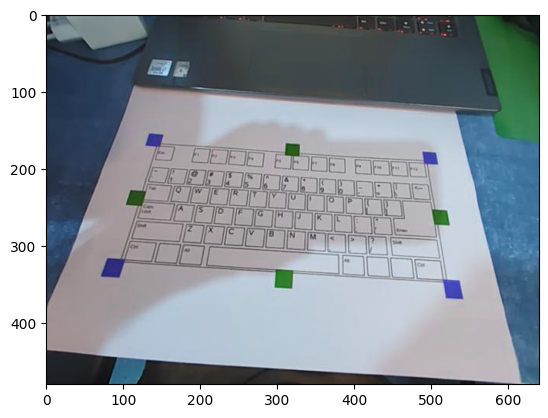

In [69]:
image_path = r'C:\Users\Reuven\PycharmProjects\ProjectA\papertest\frame_0160.png'
# image_path = r'C:\Users\Reuven\PycharmProjects\ProjectA\papertest\frame_0088.png'
image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
# keyboard_segmentation.segment_keyboard(image)
# keyboard_segmentation.green_coordinates
# keyboard_image = keyboard_segmentation._project_keyboard_image(image, keyboard_segmentation.homography_matrix)

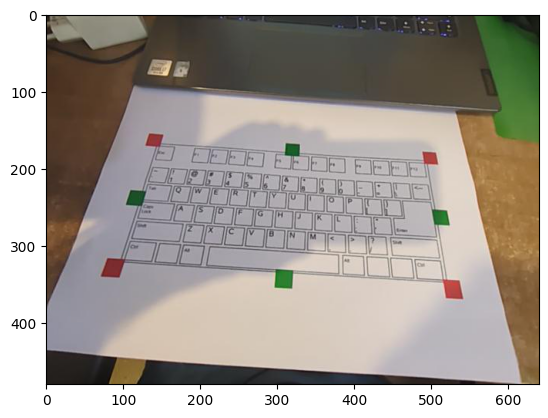

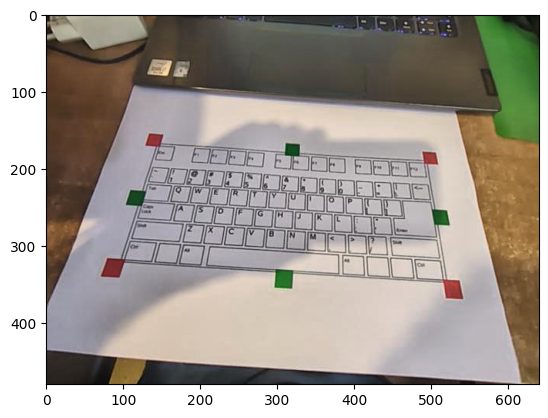

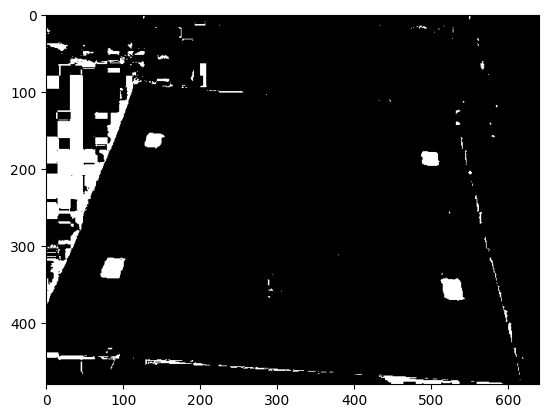

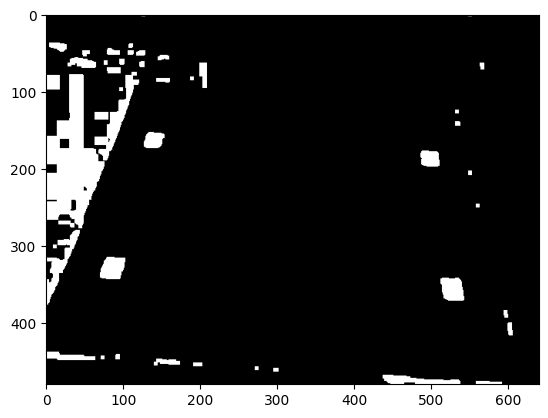

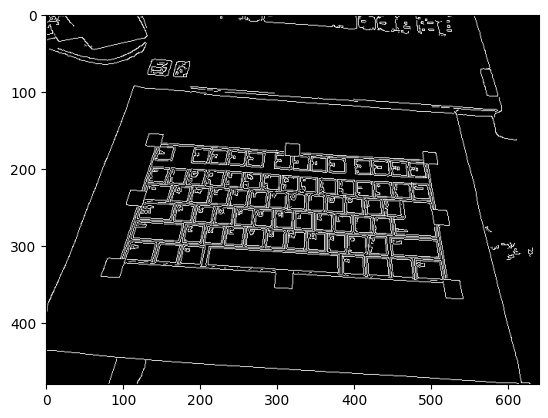

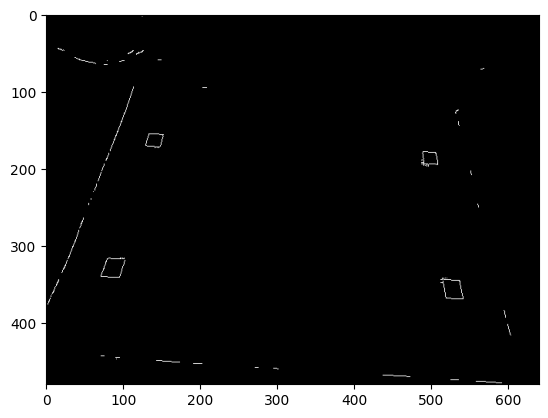

[(129, 155, 24, 19),
 (487, 178, 22, 20),
 (28, 280, 15, 38),
 (71, 316, 32, 26),
 (512, 342, 30, 28)]

In [70]:
color = 'red'
original = image.copy()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
# Step 1: Increase contrast using CLAHE on the V channel
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(10, 10))
v = clahe.apply(v)
hsv = cv2.merge((h, s, v))
# hsv = cv2.GaussianBlur(hsv, (5, 5), 0)
plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
plt.show()

# Red color mask with robust thresholds
if color == 'red':
    lower_red1 = np.array([0, 40, 40])
    upper_red1 = np.array([12, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)

    lower_red2 = np.array([170, 40, 40])
    upper_red2 = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    # mask = mask1
    mask = mask1 + mask2
elif color == 'green':
    lower_green = np.array([35,40,40])
    upper_green = np.array([85,255,255])

    mask = cv2.inRange(hsv, lower_green, upper_green)
else:
    raise TypeError(f"Color {color} is invalid")

plt.imshow(mask, cmap='gray')
plt.show()

kernel = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel, iterations=1)

plt.imshow(mask, cmap='gray')
plt.show()

# Step 4: Canny edge detection to find shapes
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150)

plt.imshow(edges, cmap='gray')
plt.show()

# Combine red mask and edges (bitwise AND)
mask = cv2.bitwise_and(mask, edges)
plt.imshow(mask, cmap='gray')
plt.show()

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
objects = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if 10 < w < 40 and 10 < h < 40:  # Filtering based on expected small size
        objects.append((x, y, w, h))
objects = sorted(
    objects, key=lambda x: (x[1], x[0])
)  # Sort by y, then by x
objects

# plt.imshow(mask)
# plt.show()

In [24]:

def plot_histograms(image, title_prefix=''):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    colors = ['r', 'g', 'b']
    names = ['Hue', 'Saturation', 'Value']
    channels = [h, s, v]

    plt.figure(figsize=(15, 4))
    for i, (channel, color, name) in enumerate(zip(channels, colors, names)):
        plt.subplot(1, 3, i+1)
        plt.hist(channel.ravel(), 256, [0, 256], color=color, alpha=0.7)
        plt.title(f'{title_prefix}{name} Histogram')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

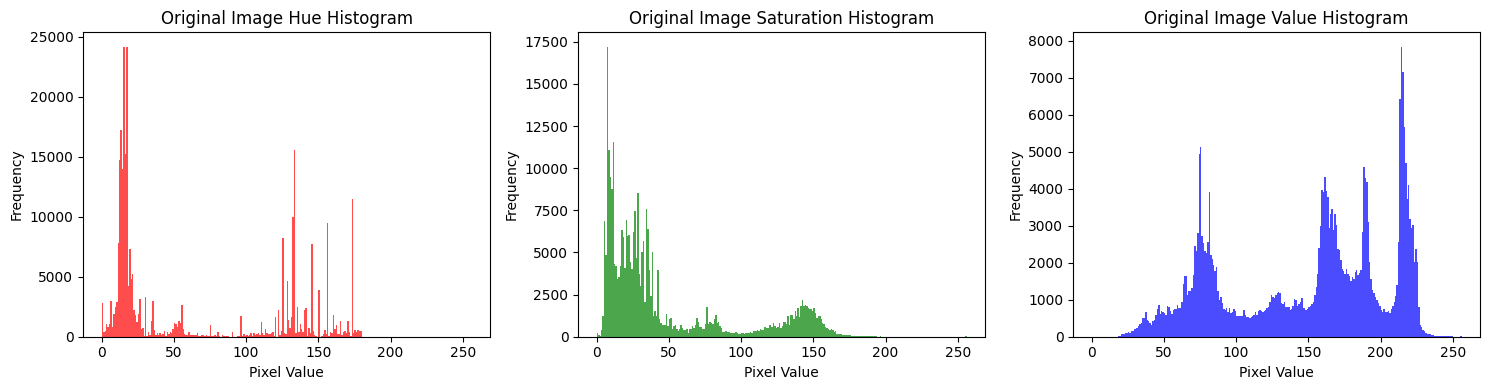

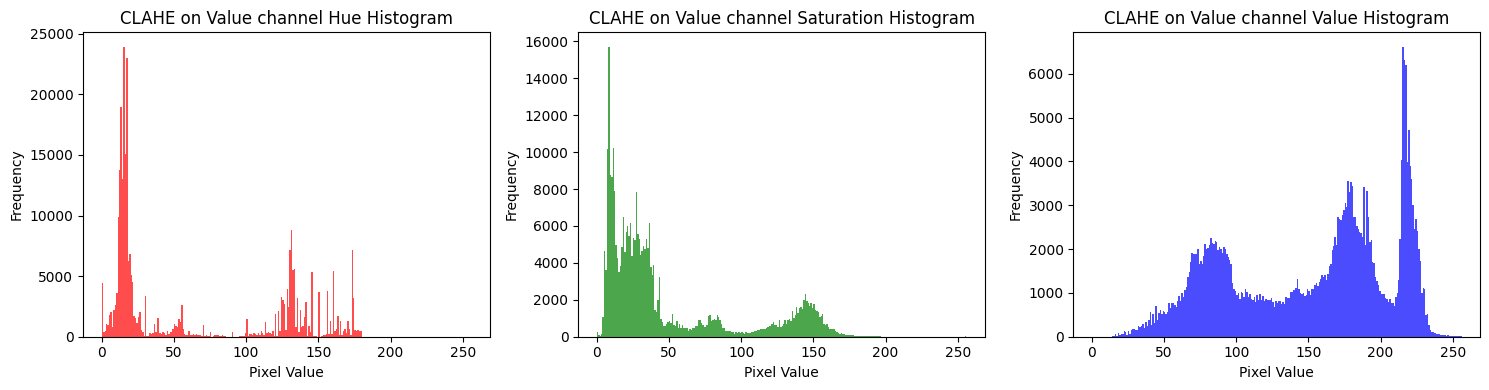

In [28]:
plot_histograms(image, 'Original Image ')
plot_histograms(cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR), 'CLAHE on Value channel ')


In [35]:
def is_white(pixel, threshold=80):
    # pixel: (B, G, R)
    return pixel[0] > threshold and pixel[1] > threshold and pixel[2] > threshold

def has_white_border(image, x, y, w, h, margin=20, white_thresh=0.6):
    h_img, w_img, _ = image.shape
    # Coordinates with margin (clamped to image bounds)
    x1 = max(x - margin, 0)
    y1 = max(y - margin, 0)
    x2 = min(x + w + margin, w_img)
    y2 = min(y + h + margin, h_img)

    # Create a mask for just the border area
    mask = np.zeros((y2 - y1, x2 - x1), dtype=np.uint8)
    mask[:margin, :] = 1     # top
    mask[-margin:, :] = 1    # bottom
    mask[:, :margin] = 1     # left
    mask[:, -margin:] = 1    # right

    border_region = image[y1:y2, x1:x2]
    white_pixels = 0
    total = np.count_nonzero(mask)

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j] == 1 and is_white(border_region[i, j]):
                white_pixels += 1
    print(white_pixels / total)
    return (white_pixels / total) >= white_thresh

def mean_pixels(image, x, y, w, h):
    h_img, w_img, _ = image.shape
    x1 = max(x, 0)
    y1 = max(y, 0)
    x2 = min(x + w, w_img)
    y2 = min(y + h, h_img)
    border_region = image[y1:y2, x1:x2]
    return cv2.mean(border_region)



1.0
has_white=True (129, 155, 24, 19) mean_pixels(image, x, y, w, h)=(90.11184210526315, 85.1469298245614, 147.72587719298244, 0.0)
1.0
has_white=True (487, 178, 22, 20) mean_pixels(image, x, y, w, h)=(105.98181818181817, 108.91590909090908, 178.5090909090909, 0.0)
0.5043010752688172
0.9989795918367347
has_white=True (71, 316, 32, 26) mean_pixels(image, x, y, w, h)=(79.02764423076924, 74.81971153846155, 130.36298076923077, 0.0)
1.0
has_white=True (512, 342, 30, 28) mean_pixels(image, x, y, w, h)=(115.05833333333334, 118.7702380952381, 192.94404761904764, 0.0)
0 1
1 2
2 3
3 0


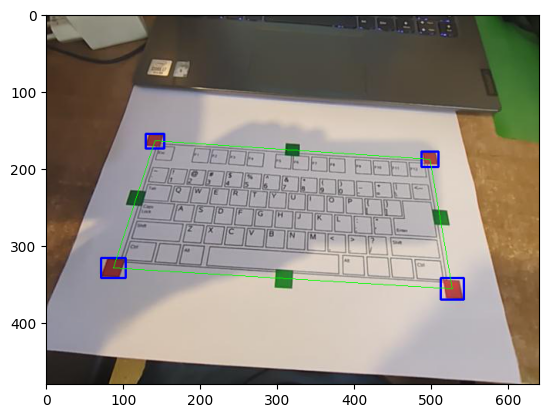

In [46]:
annotated_image = image.copy()
annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
centers = []
for (x, y, w, h) in objects:
    has_white = has_white_border(image, x, y, w, h)
    if has_white:
        rgb_color = (0, 0, 255)
        cx, cy = x + w // 2, y + h // 2
        centers.append((cx, cy))
        print(f"{has_white=} {x, y, w, h} {mean_pixels(image, x, y, w, h)=}")
    else:
        continue
    cv2.rectangle(annotated_image, (x, y), (x + w, y + h), rgb_color, 2)  # Red outline, thickness 2
centers = [centers[0], centers[1], centers[3], centers[2]]
for i, (cx1, cy1) in enumerate(centers):
    for j, (cx2, cy2) in enumerate(centers):
        if (j - i) % 4 == 1:
            cv2.line(annotated_image, (cx1, cy1), (cx2, cy2), (0, 255, 0), 1)
            print(i, j)

plt.imshow(annotated_image)
plt.show()

similarity=np.float64(0.09658626390381239)
keyboard_segmentation._is_keyboard_image(keyboard_image)=False


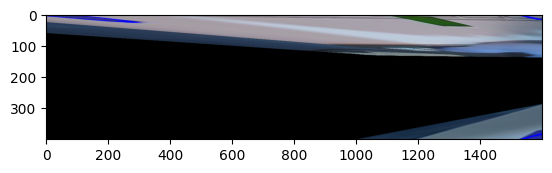

In [88]:
src_points, dst_points = keyboard_segmentation.get_matching_points(image, how='red')
keyboard_segmentation.homography_matrix = keyboard_segmentation._compute_homography(src_points, dst_points)
keyboard_image = keyboard_segmentation._project_keyboard_image(image, keyboard_segmentation.homography_matrix)
print(f"{keyboard_segmentation._is_keyboard_image(keyboard_image)=}")
plt.imshow(keyboard_image)

Circle centered at (141, 164) with radius 5
Circle centered at (498, 188) with radius 5
Circle centered at (527, 356) with radius 5
Circle centered at (87, 329) with radius 5


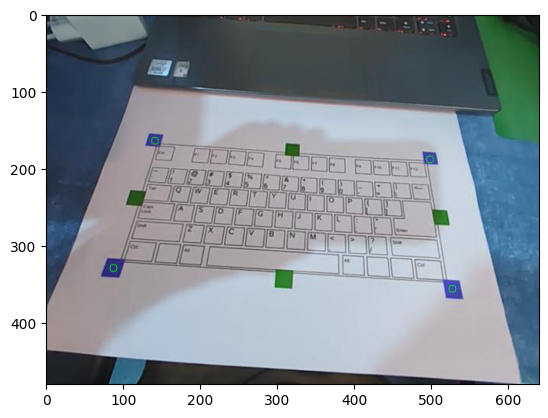

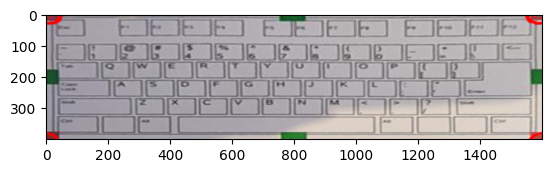

In [47]:
# Iterate over each coordinate and draw a circle around it
image_annotated = image.copy()
for coord in keyboard_segmentation.red_coordinates:
    x, y = coord
    radius = 5
    
    # Draw circle around the point
    cv2.circle(image_annotated, (x, y), radius, (0, 255, 0), 1)  # green color
    
    # Print the coordinate points for reference
    print(f"Circle centered at ({x}, {y}) with radius {radius}")
plt.imshow(image_annotated)
plt.show()
plt.imshow(cv2.cvtColor(keyboard_segmentation._keyboard_image_internal, cv2.COLOR_BGR2RGB))
plt.show()
keyboard_image_internal = keyboard_segmentation._keyboard_image_internal.copy()
# keyboard_image_internal = keyboard_image.copy()

similarity=np.float64(0.7971988687079038)


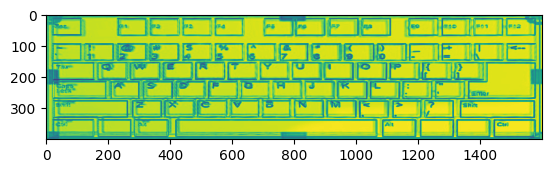

In [48]:
from skimage.metrics import structural_similarity as ssim
layout_keyboard_image_gray = cv2.imread('Project_A/keyboard_map.jpg', cv2.IMREAD_GRAYSCALE)
        # layout_keyboard_image_gray = cv2.rotate(layout_keyboard_image_gray, cv2.ROTATE_180)
cam_keyboard_image_gray = cv2.cvtColor(keyboard_image_internal, cv2.COLOR_BGR2GRAY)
layout_keyboard_image_gray = cv2.resize(layout_keyboard_image_gray,
                                        (cam_keyboard_image_gray.shape[1], cam_keyboard_image_gray.shape[0]))
similarity, diff = ssim(layout_keyboard_image_gray, cam_keyboard_image_gray, gaussian_weights=True, sigma=0.3, full=True)
print(f"{similarity=}")
plt.imshow(diff)
plt.show()

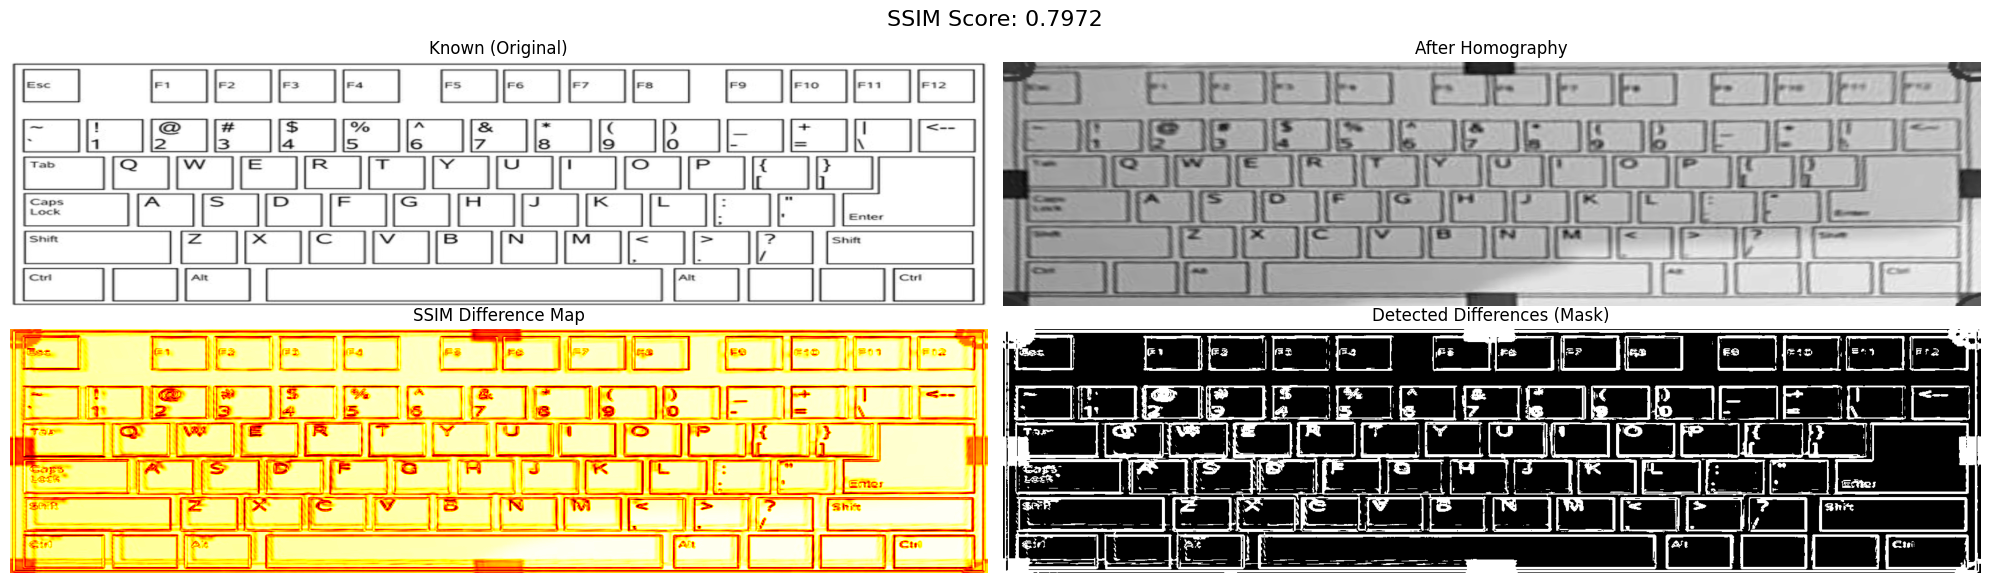

In [61]:
diff_int = (diff * 255).astype("uint8")
thresh = cv2.threshold(diff_int, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# הצגה
fig, axs = plt.subplots(2, 2, figsize=(20, 6))

axs[0, 0].imshow(layout_keyboard_image_gray, cmap='gray')
axs[0, 0].set_title("Known (Original)")
axs[0, 0].axis("off")

axs[0, 1].imshow(cam_keyboard_image_gray, cmap='gray')
axs[0, 1].set_title("After Homography")
axs[0, 1].axis("off")

axs[1, 0].imshow(diff, cmap='hot')
axs[1, 0].set_title("SSIM Difference Map")
axs[1, 0].axis("off")

axs[1, 1].imshow(thresh, cmap='gray')
axs[1, 1].set_title("Detected Differences (Mask)")
axs[1, 1].axis("off")

plt.suptitle(f"SSIM Score: {similarity:.4f}", fontsize=16)
plt.tight_layout()
plt.show()

In [23]:
finger_point = (600, 420)
projected_point = keyboard_segmentation.project_point(finger_point)
print(f"{projected_point=}")
image_annotated = image.copy()
keyboard_image_annotated = keyboard_image.copy()

radius = 5
thickness = 3
color = (0, 0, 255)  # Red
cv2.circle(image_annotated, finger_point, radius, color, thickness)
cv2.circle(keyboard_image_annotated, projected_point, radius, color, thickness)
position = (10, 60)  # Top-left corner (x, y)
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 3
color = (255, 0, 0)  # Red color in BGR
thickness = 2

keyboard_layout_obj = Keyboard_Layout((keyboard_segmentation.homography_width,
                                            keyboard_segmentation.homography_height))
key = keyboard_layout_obj.get_key_by_index(*projected_point)
key.key_name

# Add text on top-left corner of the image
keyboard_image_annotated = cv2.putText(keyboard_image_annotated, key.key_name, position, font, font_scale, color, thickness)

plt.imshow(image_annotated)
plt.show()
plt.imshow(keyboard_image_annotated)
key.key_name

projected_point=(-1, -1)


AttributeError: 'NoneType' object has no attribute 'key_name'

In [24]:
keyboard_segmentation.homography_height

400

In [ ]:
gray_image = cv2.cvtColor(keyboard_image, cv2.COLOR_BGR2GRAY)
white_intensity = float(np.sum(gray_image) / (255.0 * gray_image.size))
white_intensity

0.6078303799019608

In [ ]:
plt.imshow(gray_image, cmap='gray')